Expected SARSA: 90%

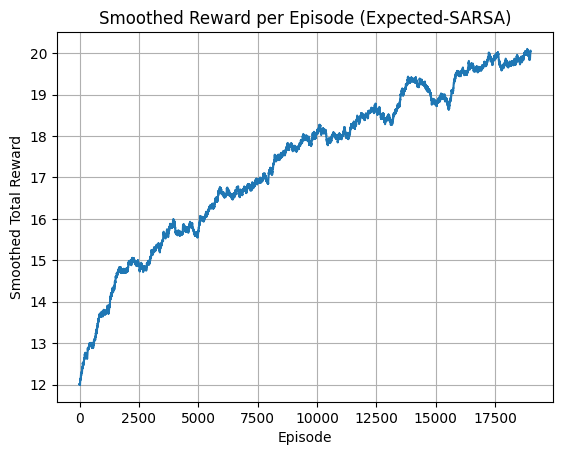


Average reward over last 1000 episodes: 20.04

Done!


In [6]:
from collections import defaultdict
import time
import gymnasium as gym
import highway_env
import highway_env.envs
import highway_env.envs.common
import highway_env.envs.common.observation
from matplotlib import pyplot as plt
import numpy as np

class HighwayAgent:
    def __init__(self, method, env, alpha = 0.3, gamma = 0.9, epsilon_start = 0.8, epsilon_decay = 0.99997, epsilon_min = 0.1):
        self.method = method
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_values = np.zeros((1000, env.action_space.n))
        self.q_values2 = np.zeros((1000, env.action_space.n))
    
    def getAction(self, state, isOptimal = False):  # isOptimal = True, in case you want completely greedy (usually used in testing)
        q_values =  self.q_values + self.q_values2 if self.method == 'Double Q' else self.q_values
        if np.random.rand() > self.epsilon or isOptimal:
            return np.argmax(q_values[state])
        else:
            return self.env.action_space.sample()
            
        
    def update(self, state, action, reward, next_state, next_action, done):
            if self.method == 'SARSA':
                self.q_values[state, action] += self.alpha * (reward + self.gamma * self.q_values[next_state, next_action] * (not done) - self.q_values[state, action]) 

            elif self.method == 'Expected SARSA':
                action_prob = np.ones(self.env.action_space.n) * (self.epsilon / self.env.action_space.n)
                best_action = self.getAction(next_state, True)
                action_prob[best_action] += (1 - self.epsilon)
                expected =  np.dot(action_prob, self.q_values[next_state])
                self.q_values[state, action] += self.alpha * (reward + self.gamma * expected * (not done) - self.q_values[state, action])
            
            elif self.method == 'Q':
                self.q_values[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_values[next_state]) * (not done) - self.q_values[state, action])

            elif self.method == 'Double Q':
                if np.random.rand() > 0.5:
                    next_action = np.argmax(self.q_values[next_state])
                    self.q_values[state, action] += self.alpha * (reward + self.gamma * self.q_values2[next_state, next_action] * (not done) - self.q_values[state, action])
                else:
                    next_action = np.argmax(self.q_values2[next_state]) 
                    self.q_values2[state, action] += self.alpha * (reward + self.gamma * self.q_values[next_state, next_action] * (not done) - self.q_values2[state, action])
        

    def decayEpsilon(self, episode):
        self.epsilon = max(self.epsilon_min, self.epsilon_start * (self.epsilon_decay ** episode))

class CustomHighwayObs(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.ego = env.unwrapped.vehicle


    def reset(self, **kwargs):
            obs, info = self.env.reset(**kwargs)
            modified_obs = self.cont2discrete(obs)
            return modified_obs, info

    def step(self, action):
        # Original environment step function, obs is TTC
        obs, reward, terminated, truncated, info = self.env.step(action)
        modified_obs = self.cont2discrete(obs)

        return modified_obs, reward, terminated, truncated, info
    
    def cont2discrete(self, obs):
        ego_speed = self.ego.speed
        speed_index = 0 if ego_speed <= 15 else 1 if ego_speed <= 20 else 2

        # Select the appropriate speed layer (3 lanes x bins)
        lanes = obs[speed_index]
        ttc_bins = []

        for lane in lanes:
            # Find the first non-zero index (i.e., closest vehicle)
            non_zero_indices = np.nonzero(lane)[0]
            if len(non_zero_indices) == 0:
                ttc = 9  # Treat as farthest bin
            else:
                ttc = min(non_zero_indices[0], 9)  # Cap value at 9

            ttc_bins.append(ttc)

        # Encoding: 100 * left + 10 * center + right
        return ttc_bins[0] * 100 + ttc_bins[1] * 10 + ttc_bins[2]



            
def train(method, num_episodes = 40_000, alpha = 0.3, gamma = 0.9, epsilon_start = 0.8, epsilon_decay = 0.9999, epsilon_min = 0.1, showProgress = False):             
    env = gym.make(
        'highway-fast-v0',  
        config = {
        "observation": {
            "type": "TimeToCollision",
        },
        "vehicles_count": 5,

    }
    )

    env = CustomHighwayObs(env)

    agent = HighwayAgent(method, env, alpha, gamma, epsilon_start, epsilon_decay, epsilon_min)
    max_steps = 50
    episode_rewards = []
    for episode in range(num_episodes):
        state = env.reset()[0]
        action = agent.getAction(state)
        total_reward = steps = 0
        done = False
        # Episode Start
        while not done and steps <= max_steps:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = agent.getAction(next_state)
            done = terminated or truncated
            total_reward += reward

            agent.update(state, action, reward, next_state, next_action, done)

            action = next_action
            state =  next_state
            steps += 1
        # Episode end
        
        episode_rewards.append(total_reward)
        agent.decayEpsilon(episode)

        if showProgress and episode % (num_episodes/10) == 0:
            print(f'\r{method}: {int(episode/num_episodes*100)}%', end='', flush=True)

    env.close()
    return episode_rewards, env, agent

rewards,  env, agent = train("Expected SARSA", num_episodes=20000, showProgress=True)
env.close()

# # Raw reward plot
# plt.plot(rewards)
# plt.xlabel("Episode")
# plt.ylabel("Total Reward")
# plt.title("Reward per Episode (Q-Learning)")
# plt.grid(True)
# plt.show()

# Optional: Smoothed reward plot
def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(rewards))
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.title("Smoothed Reward per Episode (Expected-SARSA)")
plt.grid(True)
plt.show()

last_1000_avg = np.mean(rewards[-1000:])
print(f"\nAverage reward over last 1000 episodes: {last_1000_avg:.2f}")


print('\nDone!')




## Functional Approximation using Differential SARSA


99%

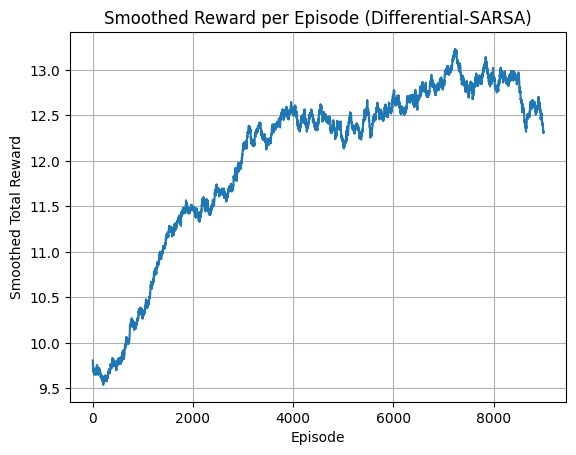


Average reward over last 1000 episodes: 12.32

Done!


In [2]:
from collections import defaultdict
import time
import gymnasium as gym
import highway_env
import highway_env.envs
import highway_env.envs.common
import highway_env.envs.common.observation
from matplotlib import pyplot as plt
import numpy as np

class TileCoder:
    def __init__(self, num_tilings, tiles_per_dim, low, high, feature_vector_size):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.feature_vector_size = feature_vector_size
        self.low = low
        self.high = high
        self.offsets = np.linspace(0, 1, num_tilings, endpoint=False)  # Offsets for tilings

    def get_features(self, s, a):
        active_tiles = []
        # Normalize state variables to [0, 1] using low and high for each dimension
        scaled_s = (s - self.low) / (self.high - self.low)

        # Iterate through each tiling
        for i in range(self.num_tilings):
            # Apply offset to each dimension after scaling
            shifted = scaled_s + self.offsets[i]
            # Compute the positions of the tiles for each dimension
            positions = np.floor(shifted * self.tiles_per_dim).astype(int)
            tile = (i, *positions, a)  # Include tiling index and action
            hashed_index = hash(tile) % self.feature_vector_size  # Hash the feature into the vector space
            active_tiles.append(hashed_index)

        features = np.zeros(self.feature_vector_size)
        # Set active tiles in the feature vector
        for idx in active_tiles:
            features[idx] = 1
        return features

class DifferentialSarsaAgent:
    def __init__(self, env, tile_coder, alpha, beta, epsilon_start, epsilon_min, epsilon_decay):
        self.tc = tile_coder
        self.alpha = alpha / tile_coder.num_tilings
        self.beta = beta
        self.epsilon = self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.avg_reward = 0.0
        self.actions = range(env.action_space.n)
        self.w = np.zeros(tile_coder.feature_vector_size)

    def select_action(self, s, isOptimal=False):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        return np.argmax([self.get_q(s, a) for a in self.actions])

    def get_q(self, s, a):
        return np.dot(self.w, self.tc.get_features(s, a))

    def update(self, s, a, r, s_next, a_next):
        x = self.tc.get_features(s, a)
        x_next = self.tc.get_features(s_next, a_next)
        delta = r - self.avg_reward + np.dot(self.w, x_next) - np.dot(self.w, x)
        self.avg_reward += self.beta * delta
        self.w += self.alpha * delta * x

    def decay_epsilon(self, episode):
        self.epsilon = max(self.epsilon_min, self.epsilon_start * (self.epsilon_decay ** episode))

def train(num_episodes=500):
    env = gym.make(
        'highway-fast-v0', 
        config = {
        "observation": {
            "type": "Kinematics",
            "features": ["presence", "x", "y", "vx", "vy"],
            "features_range": {
                "x": [0, 1],
                "y": [0, 1],
                "vx": [0, 1],
                "vy": [0, 1],
            },
        },
        "vehicles_count": 5,

    }
    )
    tile_coder = TileCoder(num_tilings=32, tiles_per_dim=16, feature_vector_size=200_000,  low=np.zeros(25), high=np.ones(25))
    agent = DifferentialSarsaAgent(env, tile_coder, alpha=0.005, beta=0.1, epsilon_start=0.95, epsilon_min=0.01, epsilon_decay=0.999)


    max_steps = 50
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()[0].flatten()
        action = agent.select_action(state)
        total_reward = steps = 0
        done = False

        # Episode Start
        while not done and steps <= max_steps:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten()
            next_action = agent.select_action(next_state)
            done = terminated or truncated
            total_reward += reward

            agent.update(state, action, reward, next_state, next_action)

            action = next_action
            state =  next_state
            steps += 1
        # Episode end
        
        episode_rewards.append(total_reward)
        agent.decay_epsilon(episode)
        if episode % (num_episodes/100) == 0:
            print(f'\r{int(episode/num_episodes*100)}%', end='', flush=True)

    env.close()
    return episode_rewards, env, agent


rewards, env, trained_agent = train(num_episodes=10000)


def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(rewards))
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.title("Smoothed Reward per Episode (Differential-SARSA)") 
plt.grid(True)
plt.show()

last_1000_avg = np.mean(rewards[-1000:])
print(f"\nAverage reward over last 1000 episodes: {last_1000_avg:.2f}")


print('\nDone!')
